# Data exploration and models comparison

In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import findspark
findspark.init()
import pyspark  
from pyspark.sql import SparkSession  
from pyspark.sql.functions import col
import datetime
from pyspark.sql import functions as f
from pyspark.conf import SparkConf
from sodapy import Socrata
import pandas as pd
import numpy as np
from pyspark.ml.feature import StandardScaler
from bigdl.chronos.forecaster.tcn_forecaster import TCNForecaster
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, TimestampType
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer, StringIndexerModel, IndexToString, PolynomialExpansion
from pymongo import MongoClient
scala_version = '2.12'
spark_version = '3.5.0'
packages = [
    f'org.apache.spark:spark-sql-kafka-0-10_{scala_version}:{spark_version}',
    'org.apache.kafka:kafka-clients:3.6.1'
]
spark = SparkSession \
.builder \
.appName("EDA") \
.master("local") \
.config("spark.executor.memory", "16g") \
.config("spark.driver.memory", "16g") \
.config("spark.python.worker.reuse", "true") \
.config("spark.sql.execution.arrow.pyspark.enabled", "true") \
.config("spark.sql.execution.arrow.maxRecordsPerBatch", "16") \
.config("spark.jars.packages", ",".join(packages)) \
.getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

conf=SparkConf()

spark

In [14]:
from bigdl.chronos.metric.forecast_metrics import Evaluator

### Data preprocessing and data visualization

In [15]:
train = spark.read.csv('Weather_train.csv', header=True, inferSchema=True)
train = train.withColumnRenamed('Air Temperature', 'air_temperature')
train = train.withColumnRenamed('Humidity', 'humidity')
train = train.withColumnRenamed('Rain Intensity', 'rain_intensity')
train = train.withColumnRenamed('Interval Rain', 'interval_rain')
train = train.withColumnRenamed('Total Rain', 'total_rain')
train = train.withColumnRenamed('Barometric Pressure', 'barometric_pressure')
train = train.withColumnRenamed('Measurement Timestamp Label', 'measurement_timestamp_label')
train = train.withColumnRenamed('Measurement Timestamp', 'measurement_timestamp')
train = train.withColumnRenamed('Measurement Timestamp Label', 'measurement_timestamp_label')
train = train.withColumnRenamed('Station Name', 'station_name')
train = train.withColumnRenamed('Wet Bulb Temperature', 'wet_bulb_temperature')
train = train.withColumnRenamed('Precipitation Type', 'precipitation_type')
train = train.withColumnRenamed('Wind Direction', 'wind_direction')
train = train.withColumnRenamed('Wind Speed', 'wind_speed')
train = train.withColumnRenamed('Maximum Wind Speed', 'maximum_wind_speed')
train = train.withColumnRenamed('Solar Radiation', 'solar_radiation')
train = train.withColumnRenamed('Heading', 'heading')
train = train.withColumnRenamed('Battery Life', 'battery_life')
train = train.withColumnRenamed('Measurement ID', 'measurement_id')
def twelve_to_twentyfour(Hour,AorP):
    hour = ''
    if (AorP == 'AM'):
        if ((int)(Hour) < 10):
            hour = "0"+(Hour)
        elif (Hour == '12'):
            hour = '00'
        else: 
            hour = Hour
    else:
        if (Hour == '12'):
            hour = '12'
        else:
            hour = ((int)(Hour) + 12)
    return hour
Hour_Converter = udf(twelve_to_twentyfour, StringType())
def timestamp_merger(date, month, year, hour):
    return (year) + "-" + (month) + "-" +(date)+ " " + (hour)+":00:00"
timestamp_merger_udf = udf(timestamp_merger, StringType())
def interval_outlier(x):
    return abs(x)
interval_outliers_udf = udf(interval_outlier, DoubleType())
train = train.withColumn('interval_rain', interval_outliers_udf(train.interval_rain))
def intensity_outlier(x):
    return abs(x)
intensity_outliers_udf = udf(intensity_outlier, DoubleType())
train = train.withColumn('rain_intensity', intensity_outliers_udf(train.rain_intensity))
def timestamp_adder(df):
    copy = df.alias('copy')
    copy = copy.withColumn('Date',f.split(col('measurement_timestamp_label'),' ')[0])
    copy = copy.withColumn('Hour',(f.split(col('measurement_timestamp_label'),' ')[1]))
    copy = copy.withColumn('AMorPM',(f.split(col('measurement_timestamp_label'),' ')[2]))                         
    copy = copy.withColumn('Month',f.split(col('Date'),'/')[0].cast('string'))
    copy = copy.withColumn('Day',f.split(col('Date'),'/')[1].cast('string'))
    copy = copy.withColumn('Year',f.split(col('Date'),'/')[2].cast('string'))
    copy = copy.withColumn('Time', Hour_Converter(f.split(copy.Hour,':')[0], copy.AMorPM).cast('string'))
    copy = copy.withColumn('timestamp',timestamp_merger_udf(copy.Day,copy.Month,copy.Year,copy.Time))
    copy = copy.withColumn('timestamp', f.to_timestamp('timestamp', 'yyyy-MM-dd HH:mm:ss'))
    copy = copy.orderBy('timestamp')
    copy = copy.dropna()
    return copy
train = timestamp_adder(train)
#train = train.filter(col('timestamp') >= "2020-01-01 00:00:00")

#### Correlation matrix

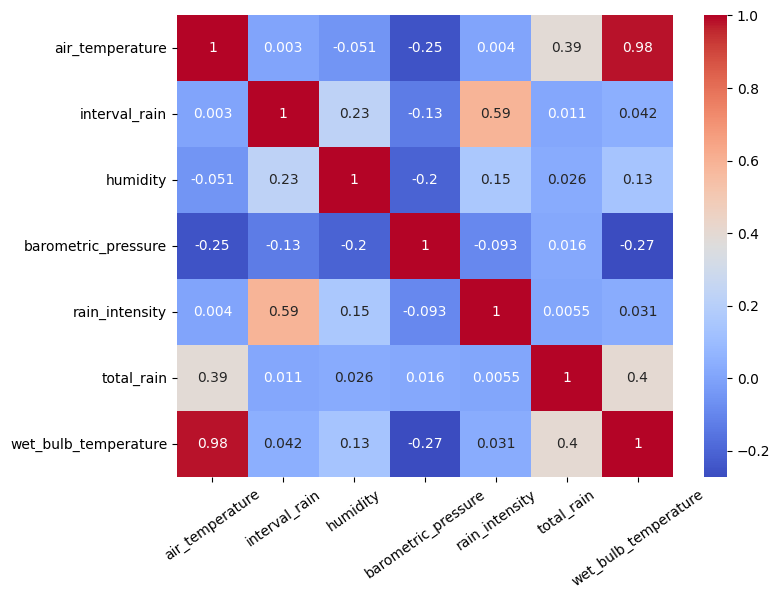

In [16]:
columns = ['air_temperature','interval_rain','humidity','barometric_pressure','rain_intensity','total_rain','wet_bulb_temperature']
def create_heatmap(df, columns):
    df = df.select(columns)
    pandas_df = df.toPandas()
    corr = pandas_df.corr()
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.xticks(rotation=35)  # Thêm dòng này để nghiêng nhãn cột x 45 độ
    plt.show()
create_heatmap(train, columns)

### Deploy models and evaluate them

#### 1. Prepare the dataset

In [4]:
look_back = 12
horizon = 1
epoch = 10
extra_feature_cols = ['rain_intensity','wet_bulb_temperature']
target_cols = ['air_temperature','interval_rain','humidity','barometric_pressure']
tsdata_train, _, tsdata_test = TSDataset.from_pandas(train.toPandas(), dt_col="timestamp", target_col=target_cols,extra_feature_col=extra_feature_cols ,with_split=True, test_ratio=0.3,repair=True)
standard_scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_test]:
    tsdata.deduplicate()\
          .impute()\
          .gen_dt_feature()\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))\
          .roll(lookback=look_back, horizon=horizon)
x_train, y_train = tsdata_train.to_numpy()
x_test, y_test = tsdata_test.to_numpy()
x_train.shape, y_train.shape, x_test.shape, y_test.shape   

D:\Spark\spark-3.5.0-bin-hadoop3\python\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


((58722, 12, 13), (58722, 1, 4), (17186, 12, 13), (17186, 1, 4))

#### 2. Build models and evaluate

##### 2.1. LSTM

In [ ]:
from bigdl.chronos.forecaster.lstm_forecaster import LSTMForecaster

In [ ]:
LSTM = LSTMForecaster(past_seq_len=x_train.shape[1],
                            input_feature_num=x_train.shape[-1],
                            output_feature_num=y_train.shape[-1],
                            hidden_dim=16,
                            layer_num=5,
                            dropout=0,
                            lr=0.001,
                            seed=0)
LSTM.fit(data=(x_train, y_train), epochs=epoch)

In [ ]:
# Make some predictions
y_pred = LSTM.predict(x_test)

In [ ]:
y_pred_unscale = tsdata_test.unscale_numpy(y_pred)
y_test_unscale = tsdata_test.unscale_numpy(y_test)
y_pred_unscale = y_pred_unscale.reshape(y_pred_unscale.shape[0],-1)
y_test_unscale = y_test_unscale.reshape(y_test_unscale.shape[0], -1)

In [ ]:
res = Evaluator.evaluate(["mse","smape","r2"],
                         y_true=y_test_unscale,
                         y_pred=y_pred_unscale)
# evaluate with mean_squared_error
print("mean squared error is", res[0])
print("sMAPE is", res[1])
print("R-2 is", res[2])

In [ ]:
for i in range(0,4):
    plt.figure(figsize=(24,6))
    plt.plot(y_pred_unscale[:,i])
    plt.plot(y_test_unscale[:,i])
    plt.legend(["prediction", "ground truth"])

##### 2.2. TCNForecaster

In [5]:
TCN = TCNForecaster(past_seq_len=look_back,  
                           future_seq_len=y_train.shape[1],  
                           input_feature_num=x_train.shape[-1],
                           output_feature_num=y_train.shape[-1],
                           kernel_size=5,
                           num_channels=[64,72,72],
                           normalization=True,
                           loss='mse',
                           dropout=0,
                           seed=0)
TCN.fit(data=(x_train, y_train), epochs=epoch)

Global seed set to 0
Global seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | NormalizeTSModel | 134 K 
1 | loss  | MSELoss          | 0     
-------------------------------------------
134 K     Trainable params
0         Non-trainable params
134 K     Total params
0.536     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [6]:
x_test, y_test = tsdata_test.to_numpy()
pred = TCN.predict(x_test)
pred_unscale, groundtruth_unscale = tsdata_test.unscale_numpy(pred), tsdata_test.unscale_numpy(y_test)
pred_unscale = pred_unscale.reshape(pred_unscale.shape[0], -1)
groundtruth_unscale = groundtruth_unscale.reshape(groundtruth_unscale.shape[0],-1)
res = Evaluator.evaluate(["mse","smape","r2"],
                         y_true=groundtruth_unscale,
                         y_pred=pred_unscale)
# evaluate with mean_squared_error
print("mean squared error is", res[0])
print("sMAPE is", res[1])
print("R-2 is", res[2])
df = spark.createDataFrame(pred_unscale[:,:])

mean squared error is 4.866897533546693
sMAPE is 25.699043178351914
R-2 is 0.9999724554010602


D:\Spark\spark-3.5.0-bin-hadoop3\python\pyspark\sql\pandas\conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


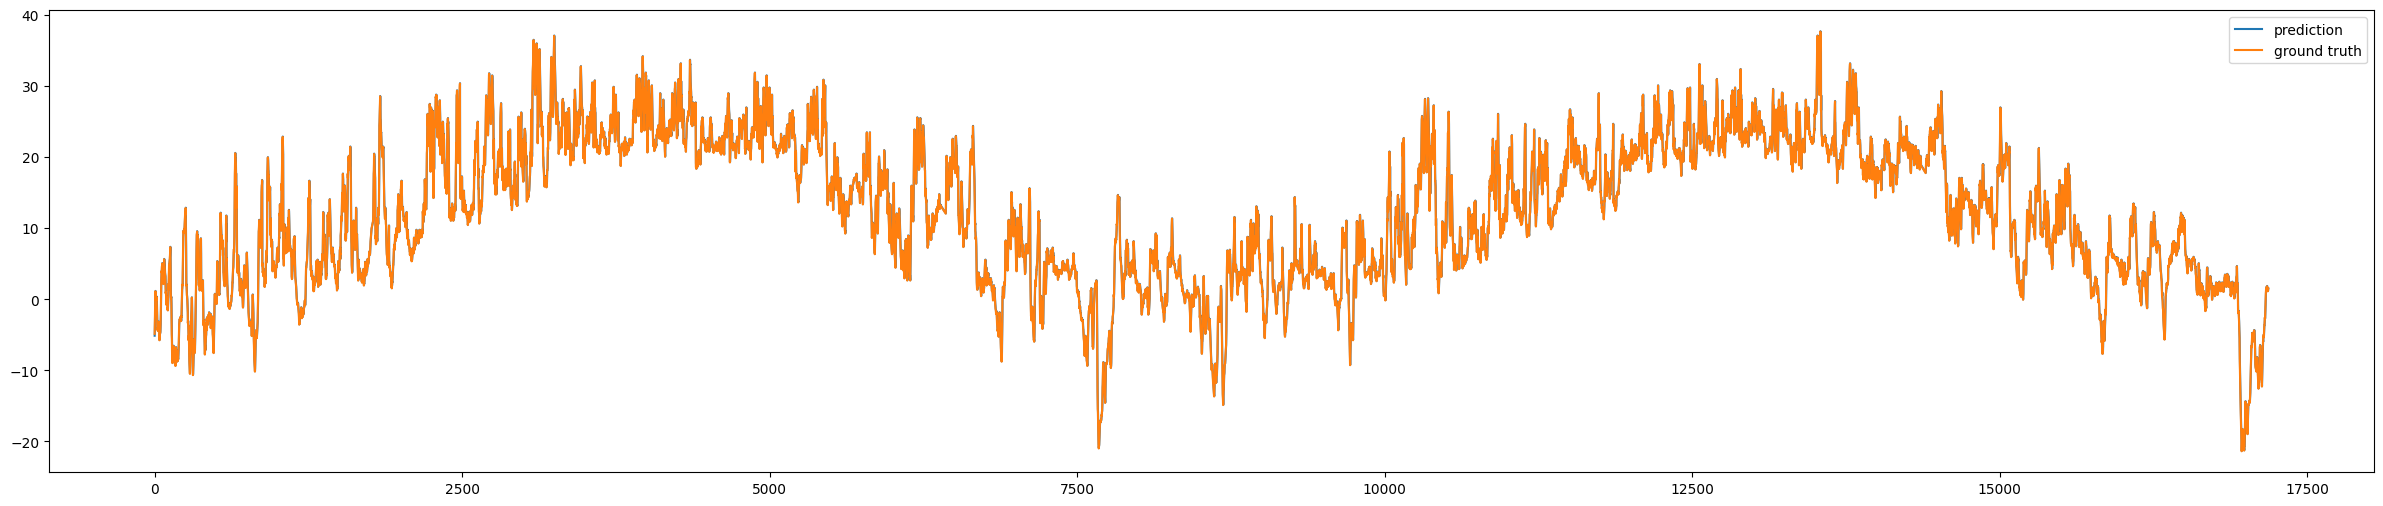

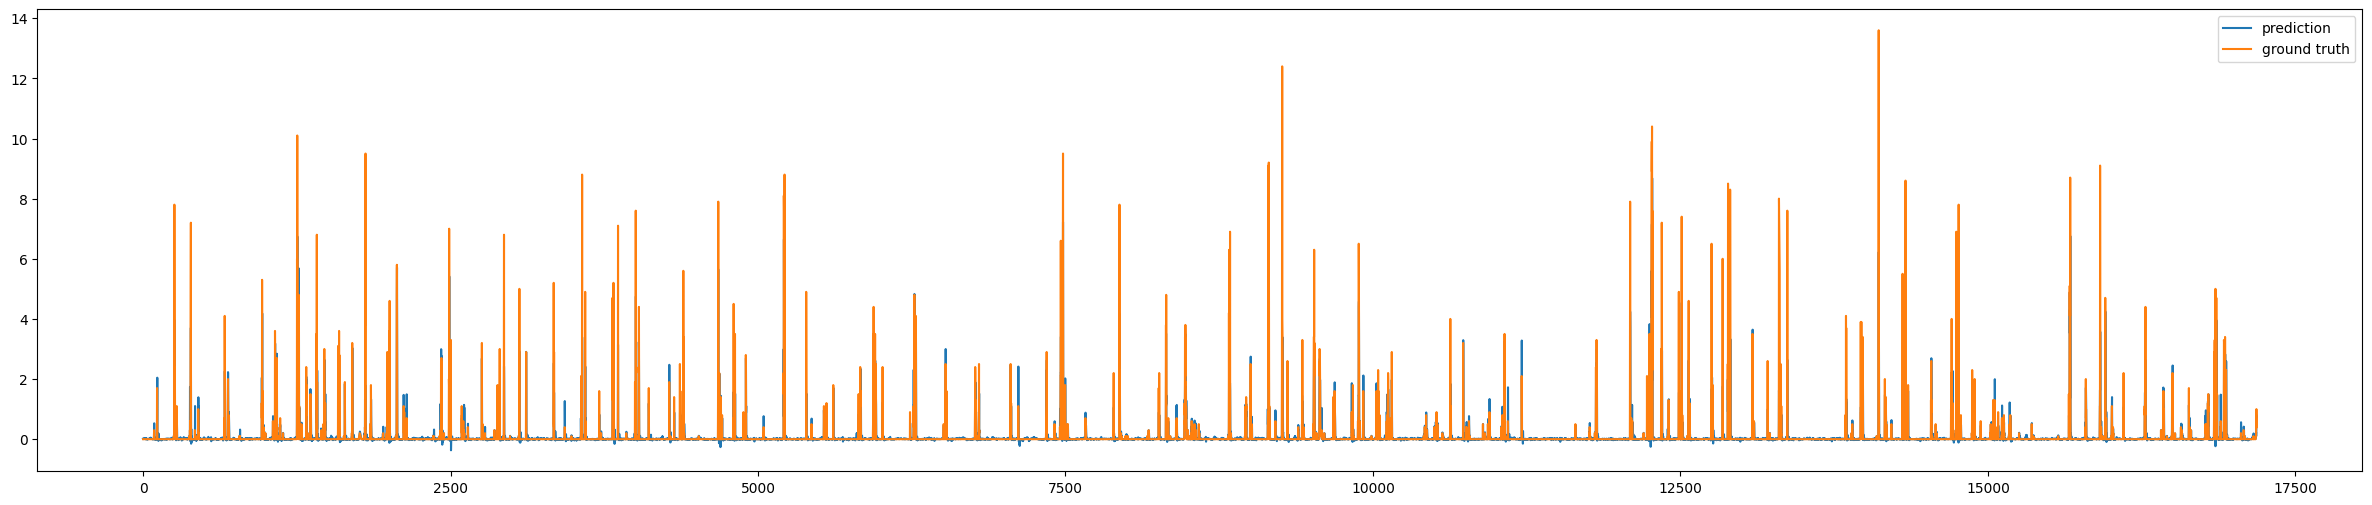

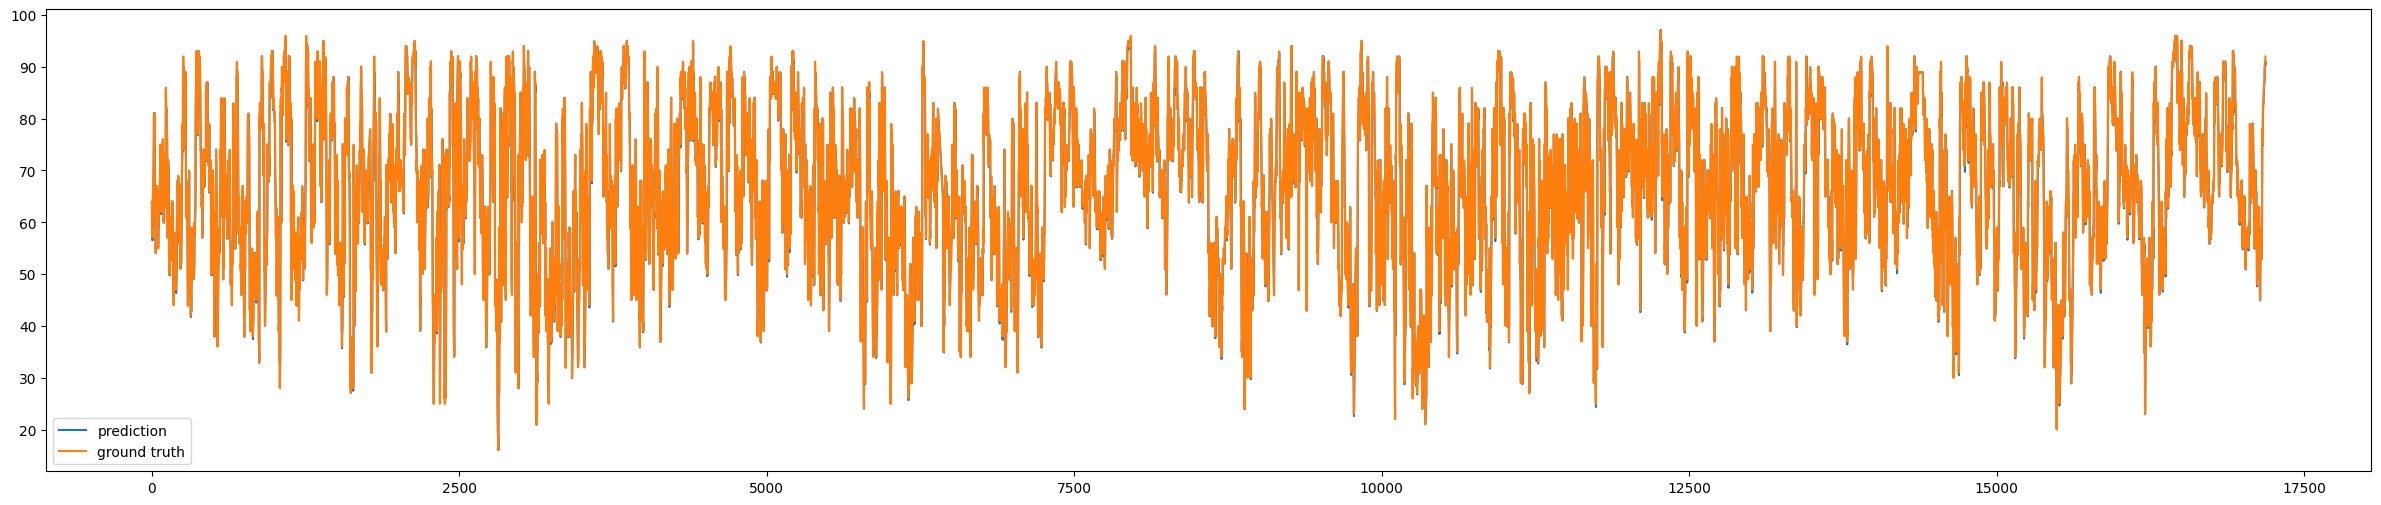

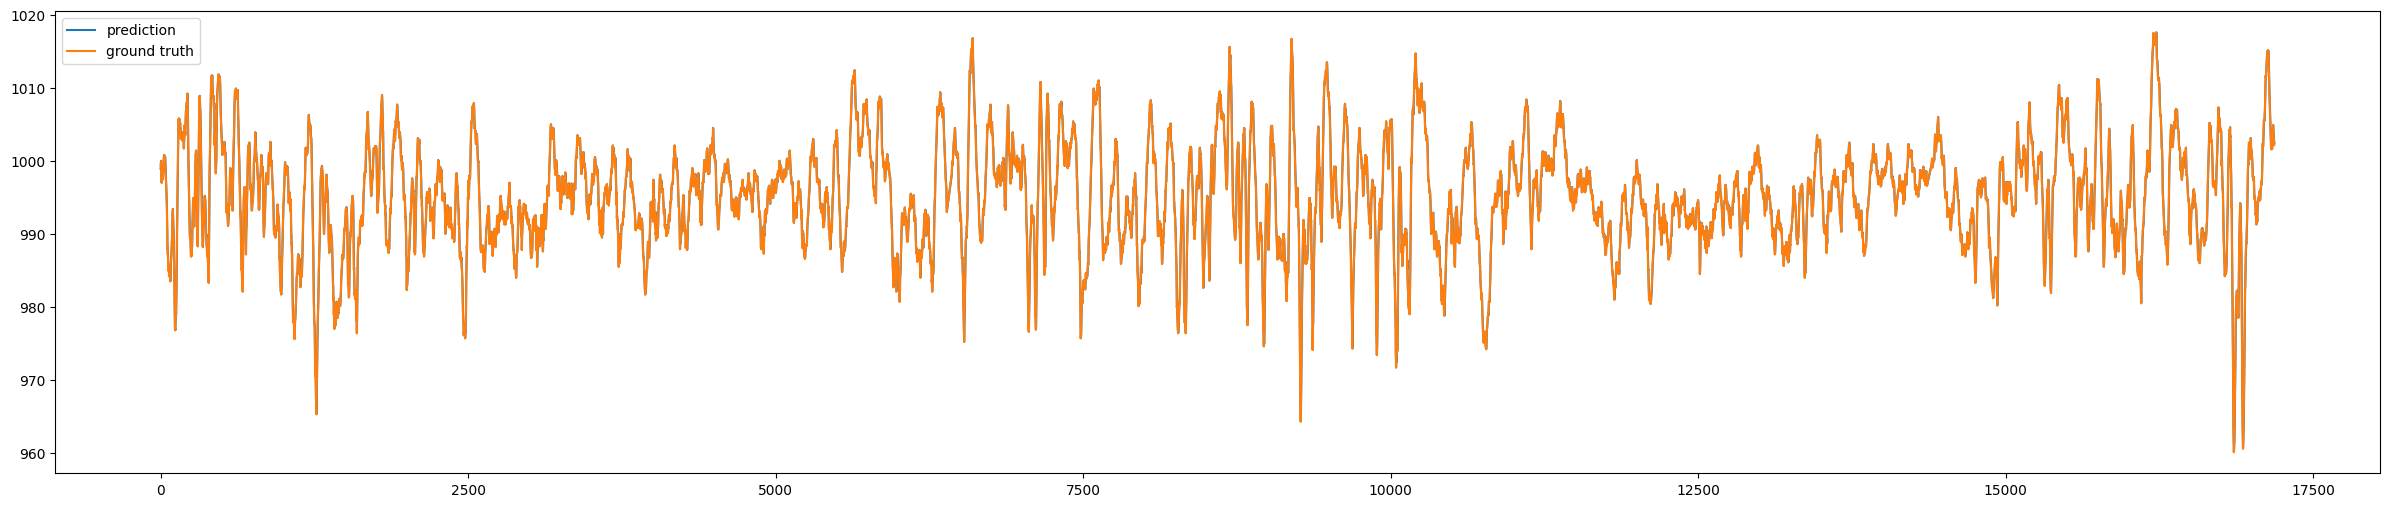

In [7]:
for i in range(0,4):
    plt.figure(figsize=(30,6))
    plt.plot(pred_unscale[:,i])
    plt.plot(groundtruth_unscale[:,i])
    plt.legend(["prediction", "ground truth"])

##### 2.3. Seq2SeqForecaster

In [8]:
from bigdl.chronos.forecaster.seq2seq_forecaster import Seq2SeqForecaster
Seq2Seq = Seq2SeqForecaster(past_seq_len=look_back,
                                   future_seq_len=horizon,
                                   input_feature_num=x_train.shape[-1],
                                   output_feature_num=y_train.shape[-1],
                                   lstm_hidden_dim=32,
                                   lstm_layer_num=4,
                                   seed=0)
Seq2Seq.fit(data=(x_train,y_train),epochs=epoch)

Global seed set to 0
Global seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | NormalizeTSModel | 61.7 K
1 | loss  | MSELoss          | 0     
-------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [9]:
x_test, y_test = tsdata_test.to_numpy()
pred = Seq2Seq.predict(x_test)
pred_unscale, groundtruth_unscale = tsdata_test.unscale_numpy(pred), tsdata_test.unscale_numpy(y_test)
pred_unscale = pred_unscale.reshape(pred_unscale.shape[0], -1)
groundtruth_unscale = groundtruth_unscale.reshape(groundtruth_unscale.shape[0],-1)
res = Evaluator.evaluate(["mse","smape","r2"],
                         y_true=groundtruth_unscale,
                         y_pred=pred_unscale)
# evaluate with mean_squared_error
print("mean squared error is", res[0])
print("sMAPE is", res[1])
print("R-2 is", res[2])
df2 = spark.createDataFrame(pred_unscale[:,:])

mean squared error is 4.823278197235965
sMAPE is 25.633889415544015
R-2 is 0.9999727022682103


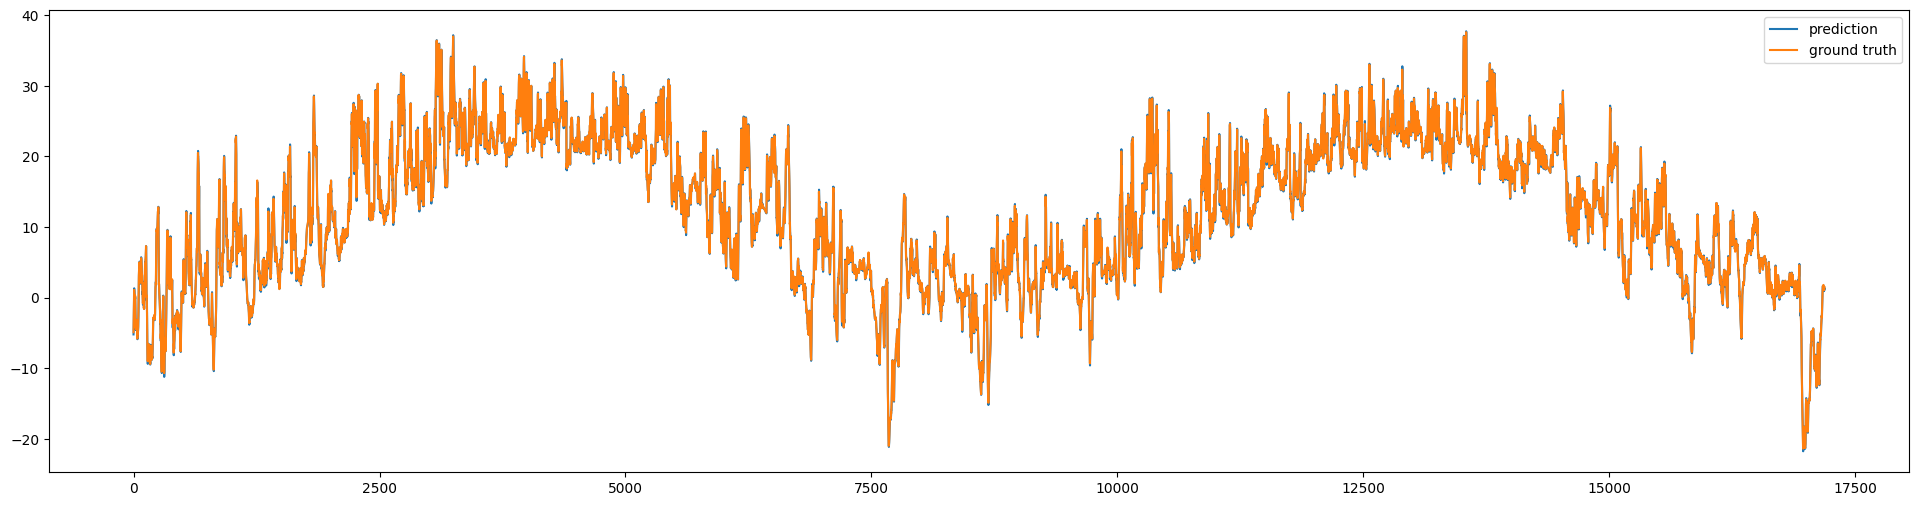

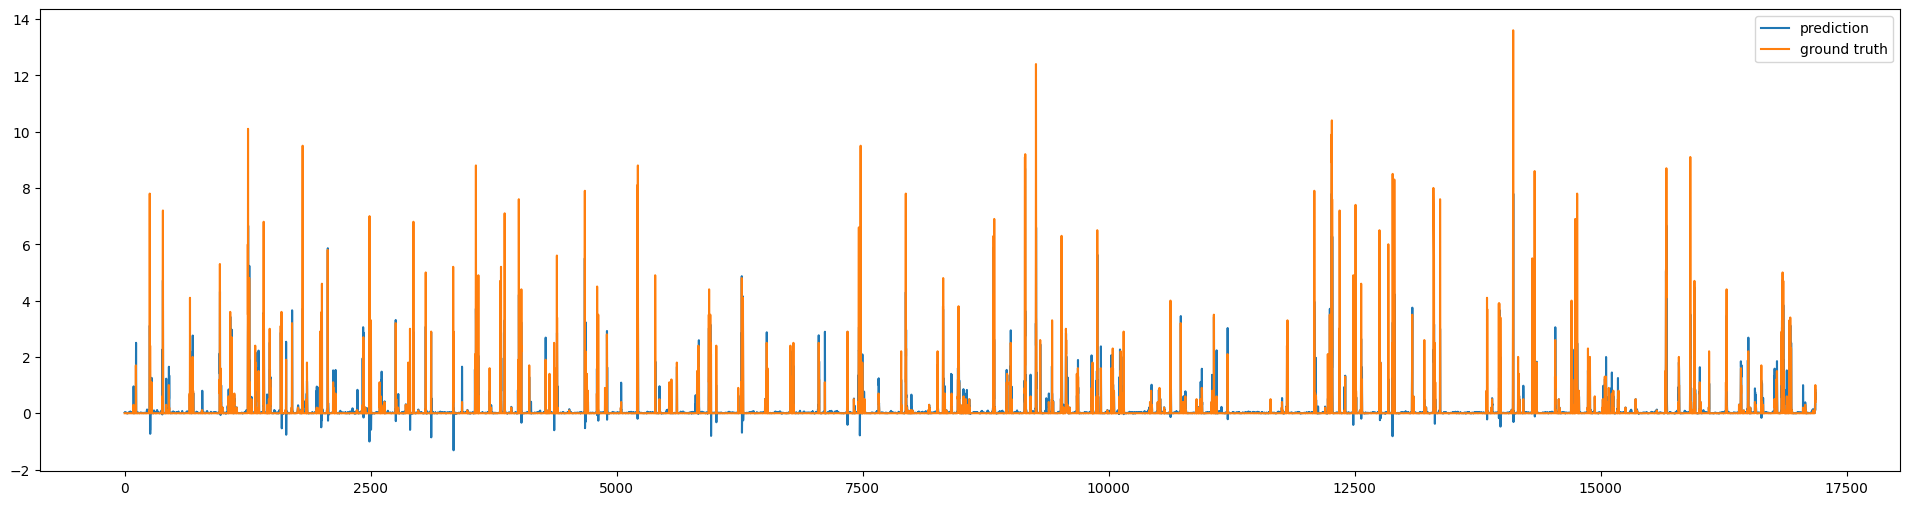

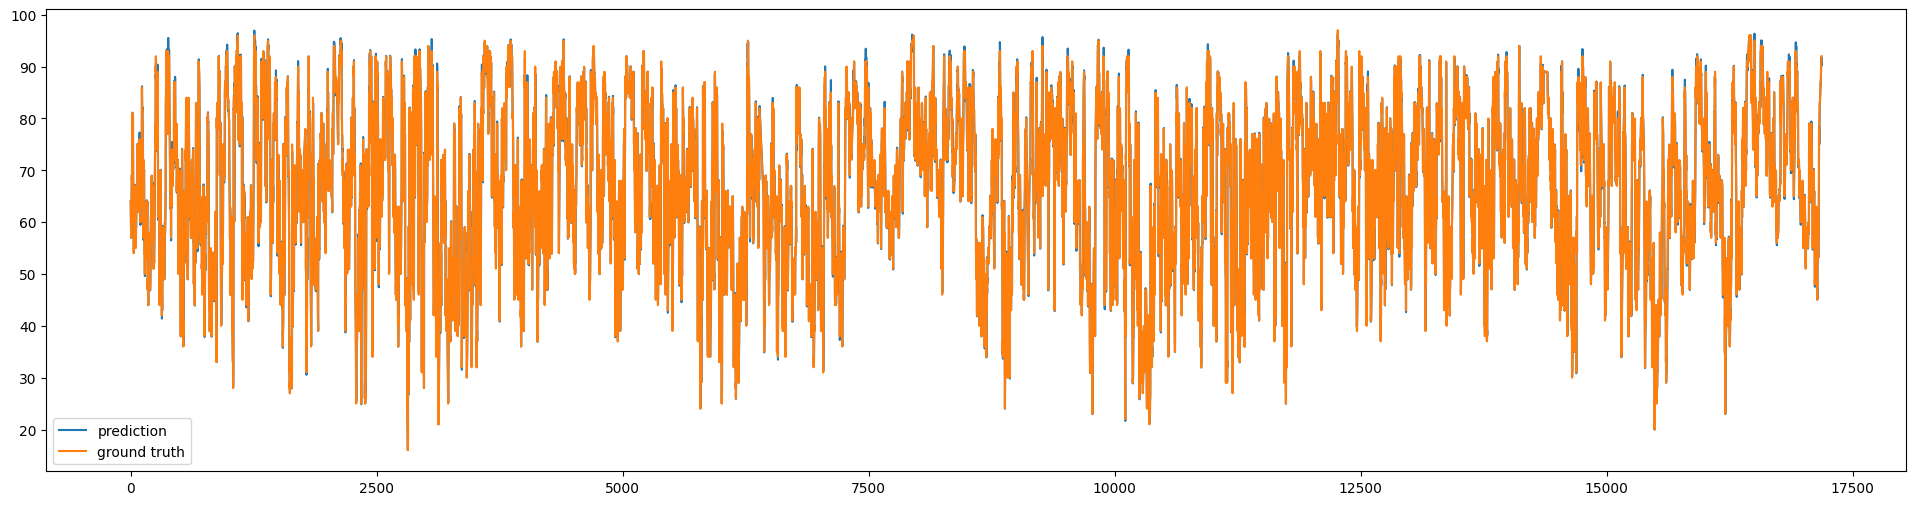

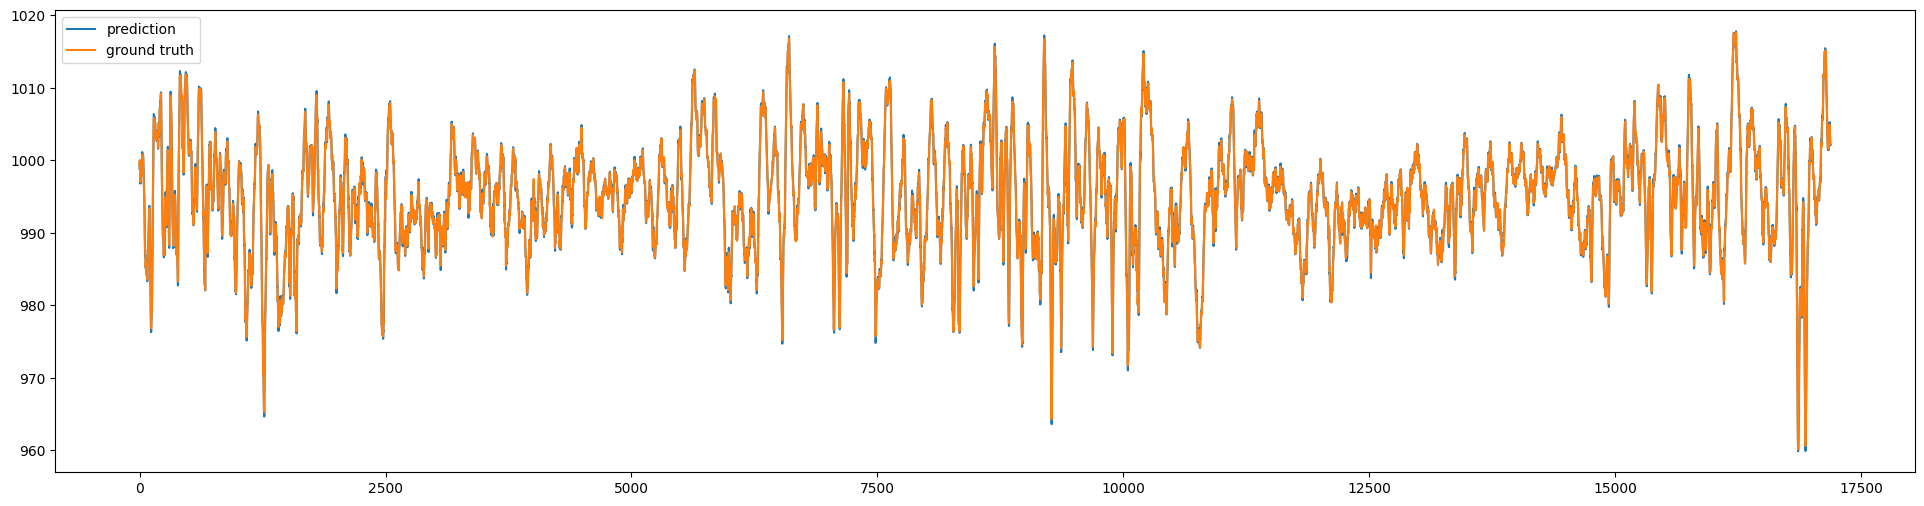

In [10]:
for i in range(0,4):
    plt.figure(figsize=(24,6))
    plt.plot(pred_unscale[:,i])
    plt.plot(groundtruth_unscale[:,i])
    plt.legend(["prediction", "ground truth"])

##### 2.4. RandomForestClassifier

In [17]:
label_Indexer = StringIndexer(inputCol='precipitation_type', outputCol='label', handleInvalid='keep')
assembler = VectorAssembler(inputCols=target_cols,outputCol='features')
poly = PolynomialExpansion(degree=2,inputCol='features',outputCol='poly_features')
scale = pyspark.ml.feature.StandardScaler(inputCol='poly_features',outputCol='scaled_features')
rf = RandomForestClassifier(featuresCol='scaled_features',labelCol='label',numTrees=100,maxDepth=10)
pipeline = Pipeline(stages=[label_Indexer,assembler,poly,scale,rf])

In [18]:
train_df, test_df = train.randomSplit([0.7, 0.3], seed=100)

In [19]:
model = pipeline.fit(train_df)

In [20]:
prediction = model.transform(test_df)

In [22]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(prediction)

print("Test Error = %g" % (1 - accuracy))

Test Error = 0.954394
